# 2.6 Resampling Methods 

Data have natural variability, which we often have to account for. 

Among other applications (e.g., uncertainity propagation or assigning confidence intervals to some statistic), **resampling methods** can help us explore this varaibility. 

Broadly, resampling refers to any technique where we repeatedly draw observations from some sample.

<!---
Note that the follow statement is specific to resampling for model evaluation:
    Resampling methods involve repeatedly drawing samples from a training set  and re-fitting a model. The collection of best-fit models provides confidence in model fitting.
More broadly, resampling methods refer to any technique where we repeatedly draw observations from some sample. We should use the more broad definition at the introduction of this section.
--->

The lecture introduces resampling techniques in several ways. We explore various fundamental examples of resampling (Level 1) and demonstrate how resampling can be used for model inference of a linear regression (Level 2).

First of all, import some useful modules:

In [1]:
import requests, zipfile, io, gzip, glob, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
# We define a random generator
rng = np.random.default_rng()

## 1. Examples of resampling techniques (Level 1)

### 1.1 Randomization

As we introduced in class: 

Given two datasets, $A$ and $B$, and a parameter, $x$, we can randomly assign observations to either $A$ or $B$, calculate some statistic (e.g., $x_A - x_B$), and repeat to build a distribution of that statistic.

In [3]:
# We begin with two datasets, A and B
A = rng.normal(5, 2.5, 100)
B = rng.normal(5.5, 2.5, 100)

# We then calculate the means of each dataset
mean_A = np.mean(A)
mean_B = np.mean(B)

print('The means of A and B are, ' + str(mean_A) + ' and ' + str(mean_B) + ', respectively.')

# And, for the sake of illustration, also calculate the difference between these means

diff_means = mean_A - mean_B

print('The difference of means is, ' + str(diff_means) + '.')

The means of A and B are, 4.8190425043357745 and 5.7062434298834965, respectively.
The difference of means is, -0.887200925547722.


Now, we will want to resample.

In [4]:
# First, how many times do we want to resample?
number_runs = 10000

In [5]:
# Next, we create an array that will store the difference of means
array_of_diffs = np.zeros([number_runs, 1])
# To ease computational burden, let's declare some variables
# A combined list of A and B
combined = np.concatenate((A, B))
# Length of A and B
length_A = len(A)

For each time we resample, we recalculate the mean and recalculate the difference 

In [6]:
# For each run:
for i in range(number_runs):
    # Let us shuffle the combined list
    # Note that shuffle works in place!
    rng.shuffle(combined)
    # Now, split the list into A and B, maintaining their original sizes
    # Notice the slice syntax!
    new_A = combined[0:length_A]
    new_B = combined[length_A:len(combined)]
    # Calculate and store a difference of means
    array_of_diffs[i] = np.mean(new_A) - np.mean(new_B)

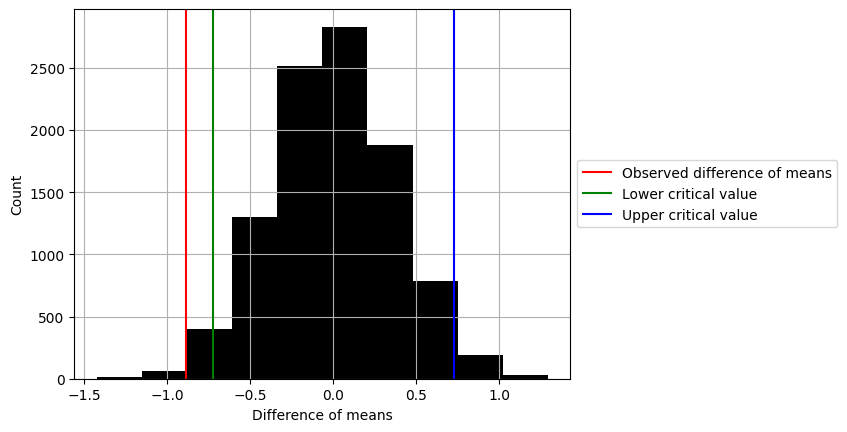

In [10]:
# Plot up the array of diffs
plt.hist(array_of_diffs, color='black')

# Given an alpha of 0.05, can we accept or reject the null hypothesis of no difference in means?

alpha = 0.05
lower_critical_value = np.quantile(array_of_diffs, alpha/2)
upper_critical_value = np.quantile(array_of_diffs, 1-(alpha/2))

# Plot the critical values and the observed value
plt.axvline(x = diff_means, color='r')
plt.axvline(x = lower_critical_value, color='g')
plt.axvline(x = upper_critical_value, color='b')
plt.xlabel('Difference of means')
plt.ylabel('Count')
plt.legend(['Observed difference of means', 'Lower critical value', 'Upper critical value'], loc='center left', bbox_to_anchor=(1, 0.5))
# Show your plot
plt.show()

### 1.2 Bootstrapping

When bootstrapping, you repeatedly draw observations, **with replacement**, from a dataset. Since you are drawing with replacement, your newly resampled dataset likely will contain duplicate observations from the original sample.

Bootstrapping does not make strong assumptions about the underlying distribution of the dataset. 

We will first create correlated data using the numpy function ``random.multivariate_normal`` ([docs here](https://numpy.org/doc/stable/reference/random/generated/numpy.random.multivariate_normal.html)). The mean of both data will be zero and their covariance is -0.75. 


In [11]:
# We begin with a dataset where two variables are strongly correlated
correlated_data= np.random.multivariate_normal([0, 0], [[1, -.75], [-.75, 1]], 1000)

First, we check that the data is indeed anticorrelated by plotting one against the other

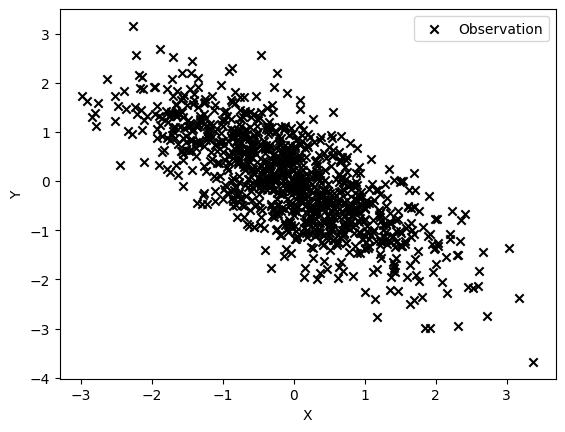

In [26]:
plt.scatter(correlated_data[:, 0], correlated_data[:, 1], marker='x', c='black')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(['Observation'])
plt.show()

We can verify that the Pearson [correlation coefficient](https://en.wikipedia.org/wiki/Correlation_coefficient) is close to our target using the numpy function ``corrcoef``.

In [16]:
# The correlation matrix of the first and second columns of correlated_data
correlation_matrix = np.corrcoef(correlated_data[:, 0], correlated_data[:, 1])

# Check the correlation coefficient
print('The correlation coefficient is: ' + str(correlation_matrix[0,1]) + '.')

The correlation coefficient is: -0.7490650993380316.


We now take a subset of the data --- think of the subset as a *sample of the true population*.

In [20]:
nsubset=10
subset = rng.choice(correlated_data, size=nsubset, replace=False)

We can calculate the correlation coefficent of this sample.

The correlation coefficient of our sample is: -0.8238774989356271.


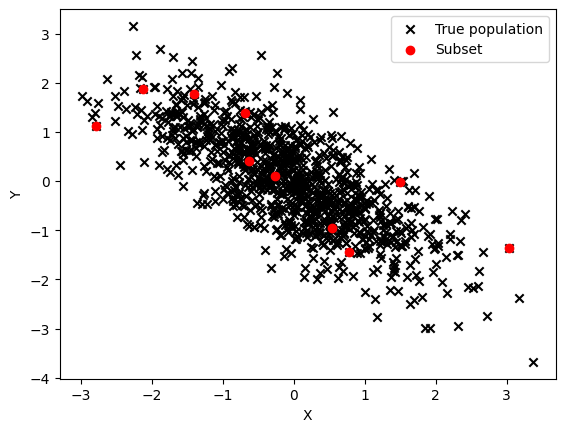

In [21]:
# Report the correlation coefficient of the subset
print('The correlation coefficient of our sample is: ' + str(np.corrcoef(subset[:,0], subset[:, 1])[0,1]) + '.')

# Plot up both the original data and our sample
plt.scatter(correlated_data[:, 0], correlated_data[:, 1], marker='x', c='black')
plt.scatter(subset[:,0], subset[:, 1], c='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(['True population', 'Subset'])
plt.show()

Now, we will bootstrap. Once again, we define a number of runs. 

In [22]:
number_runs =1000

Each time we resample, we will calculate and store the correlation coefficent of the resampled data.

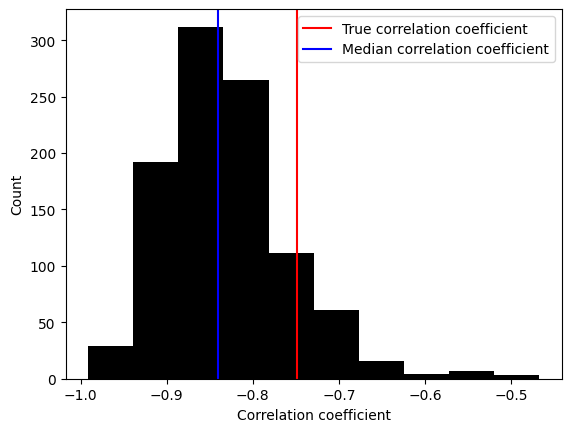

In [25]:
# Create an array that will keep track of the outputs of our resampling loop. In this case, we just want to record the correlation coefficient of each new sample. 
corr_coef_collector = np.zeros([number_runs, 1])

# Let's also get the length of the subset
# When bootstrapping, the size of your resampled dataset should match the size of your original sample!
length_sub = len(subset)

# Now, for each run
for i in range(number_runs):
    # We want to draw length_sub samples WITH REPLACEMENT
    new_pairs = rng.choice(subset, size=length_sub, replace=True)
    # Calculate and store the correlation coefficient
    corr_coef_collector[i] = np.corrcoef(new_pairs[:, 0], new_pairs[:, 1])[0,1]

# Plot up the corr_coef_collector values
plt.hist(corr_coef_collector, color='black')
plt.xlabel('Correlation coefficient')
plt.ylabel('Count')

# Show the true correlation coefficient
plt.axvline(x=correlation_matrix[0,1], color='red')
plt.axvline(x=np.median(corr_coef_collector), color='blue')
plt.legend(['True correlation coefficient', 'Median correlation coefficient'])
plt.show()

We see that the median Pearson coefficient is not exactly the true Pearson coefficient. Why is that?

What happens if you increase the size of the subset (e.g., your sample of the true population)?

### 1.3 Monte Carlo

Named after the casino in Monaco, Monte Carlo methods involve *simulating new data* based on a known (or assumed!) statistical model. Unlike the previous two examples, we do not take draws from an existing sample. 

Monte Carlo techniques have many applications. For example, you might see Monte Carlo methods used for probabilistic risk assessment, uncertainty propagation in models, and evaluating complex systems' performance. It is especially valuable when dealing with complex geospatial, environmental, or engineering models, where the relationships among variables are not easily captured by simple parametric methods.

Here, we demonstrate Monte Carlo sampling by trying to estimate $\pi$.

We begin with a central conceit: that the ratio of the area of a circle to the area of the square is $\pi/4$.

We then imagine a circle of radius 1 that is inscribed within a square with sides going from -1 to 1. 

In [28]:
# We're going to draw a (x,y) point from a *uniform* distribution and then determine whether that point sits within the circle. If it does, we append it to two lists: points within the circle and points within the square. If not, we append it only to a list of points inside the square
in_circle = np.empty([0,2])
in_square = np.empty([0,2])

# Now, let's generate many samples
# Here, we redefine number_runs for efficiency's sake
number_runs = 50

for _ in range(number_runs): # note that _ allows to avoid creating a variable
    # Okay, get an x point and a y point
    x = rng.uniform(low=-1, high=1)
    y = rng.uniform(low=-1, high=1)
    # How far is this point from the origin?
    origin_dist = x**2 + y**2
    # If origin_dist is less than 1, then this point is inside the circle
    if origin_dist <= 1:
        in_circle = np.append(in_circle, [[x, y]], axis=0)
    in_square = np.append(in_square, [[x, y]], axis=0)

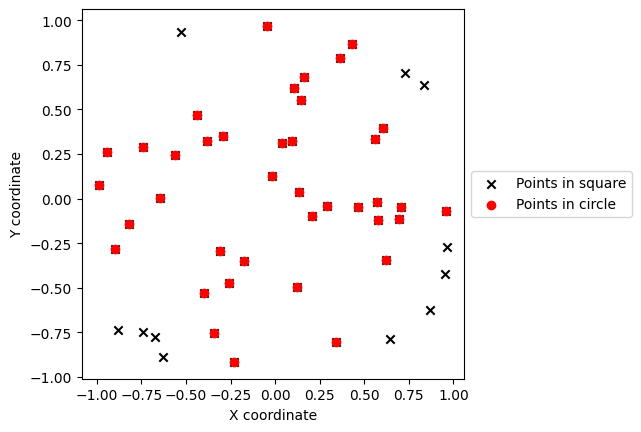

In [29]:
# We can visualize what we just did
plt.scatter(in_square[:,0], in_square[:,1], marker='x', c='black')
plt.scatter(in_circle[:,0], in_circle[:,1], marker='o', c='red')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.legend(['Points in square', 'Points in circle'], loc='center left', bbox_to_anchor=(1, 0.5))
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

We now estimate $\pi$ by using the length of the number points in the circle and in the quarter as approximation to their area.

In [30]:
# Let us estimate pi

pi_est = 4 * (len(in_circle) / len(in_square))
              
print('We estimate the value of pi to be: ' + str(pi_est) + '.')

We estimate the value of pi to be: 3.12.


Now with a few runs, we do not get a good answer. 

In fact, a Monte Carlo approach needs more runs to **converge**. 

You should explore how changing the number of runs changes your estimate of $\pi$ (and how your calculation converges).

## Using resampling for robust model inference (Level 2)

### 2.1 Plate Motion - Geodetic Data

For this tutorial, we use a GPS time series in the Pacific Northwest and explore the long term motions that are due to the Cascadia subduction zone. 

We will download GPS time series from the University of Nevada - Reno [data center](!http://geodesy.unr.edu/NGLStationPages/gpsnetmap/GPSNetMap.html).


In [32]:
# The station designation
sta="P395"
file_url="http://geodesy.unr.edu/gps_timeseries/tenv/IGS14/"+ sta + ".tenv"
r = requests.get(file_url).text.splitlines()  # download, read text, split lines into a list
ue=[];un=[];uv=[];se=[];sn=[];sv=[];date=[];date_year=[];df=[]
for iday in r:  # this loops through the days of data
    crap=iday.split()
    if len(crap)<10:
      continue
    date.append((crap[1]))
    date_year.append(float(crap[2]))
    ue.append(float(crap[6])*1000)
    un.append(float(crap[7])*1000)
    uv.append(float(crap[8])*1000)
#             # errors
    se.append(float(crap[10])*1000)
    sn.append(float(crap[11])*1000)
    sv.append(float(crap[12])*1000)

In [33]:
# We now make a data frame
crap={'station':sta,'date':date,'date_year':date_year,'east':ue,'north':un,'up':uv}
if len(df)==0:
    df = pd.DataFrame(crap, columns = ['station', 'date','date_year','east','north','up'])
else:
    df=pd.concat([df,pd.DataFrame(crap, columns = ['station', 'date','date_year','east','north','up'])])
df.describe()

,date_year,east,north,up
count,6341.000000,6341.000000,6341.000000,6341.000000
mean,2014.772434,-52.534263,-30.076831,1.899511
std,5.033255,32.520022,17.516241,5.618141
min,2006.067100,-114.314000,-65.245000,-39.508000
25%,2010.409300,-80.010000,-45.813000,-1.841000
50%,2014.765200,-49.487000,-29.918000,1.720000
75%,2019.126600,-24.855000,-14.940000,5.482000
max,2023.726200,3.927000,3.157000,28.663000


Text(0.5, 0, 'Time (years)')

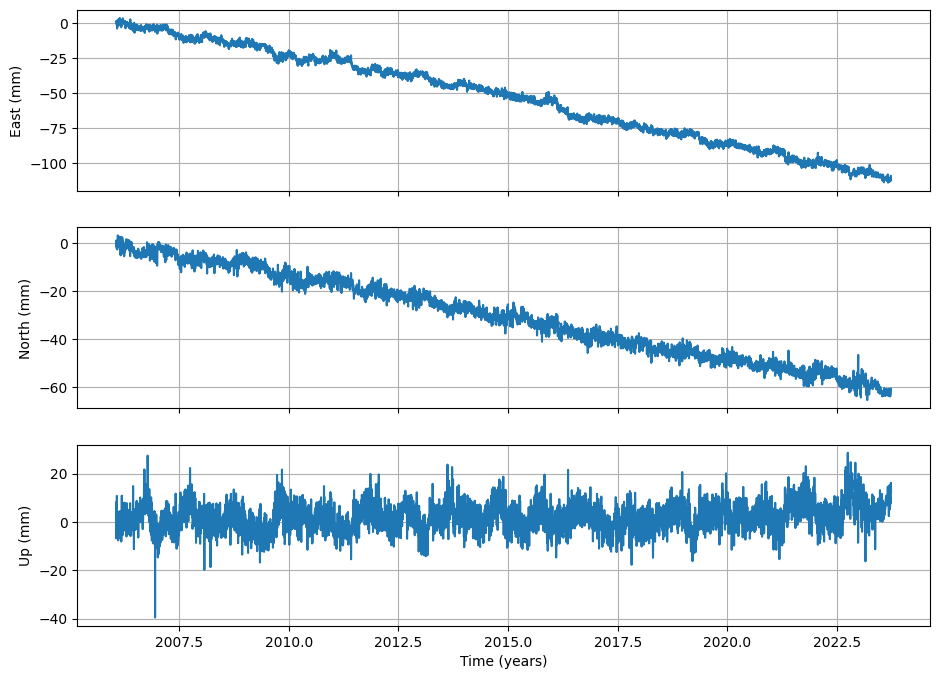

In [34]:
# Plot the GPS time series
fig,ax=plt.subplots(3,1,figsize=(11,8),sharex=True)
ax[0].plot(df['date_year'][df['station']==sta],df['east'][df['station']==sta]);ax[0].grid(True);ax[0].set_ylabel('East (mm)')
ax[1].plot(df['date_year'][df['station']==sta],df['north'][df['station']==sta]);ax[1].grid(True);ax[1].set_ylabel('North (mm)')
ax[2].plot(df['date_year'][df['station']==sta],df['up'][df['station']==sta]);ax[2].grid(True);ax[2].set_ylabel('Up (mm)')
ax[2].set_xlabel('Time (years)')

## 2.2 Linear regression

There is a clean **linear trend** in the horizontal position data over the course of the past 16 years. We can fit the data using:

$E(t) = V_e t + u_e,$\
$N(t) = V_n t + u_n,$

where $t$ is time. We want to regress the data to find the coefficients $V_e$, $u_e$, $V_n$, $u_n$. The displacements are mostly westward, so we will just focus on the East $E(t)$ component for this exercise. The coefficients $u_e$ and $u_n$ are the intercept at $t=0$. They are not zero in this case because $t$ starts in 2006. The coefficients $V_e$ and $V_n$ have the dimension of velocities:

$V_e \sim E(t) / t$ , $V_n \sim N(t) / t$ ,

therefore, we will use this example to discuss a simple **linear regression** and resampling method. We will use both a Scipy function and a Scikit-learn function.

To measure a fit performance, we will measure how well the variance is reduced by fitting the data (scatter points) against the model. The variance is:

$\text{Var}(x) = 1/n \sum_{i=1}^n (x_i-\hat{x})^2$, 

where $\hat{x}$ is the mean of $x$.  When fitting the regression, we predict the values $x_{pred}$. The residuals are the differences between the data and the predicted values: $e = x - x_{pred} $. $R^2$ or <i> coefficient of determination</i> is:

$R^2 = 1 - \text{Var}(x-x_{pred}) /\text{Var}(x)  = 1 - \text{Var}(e) /\text{Var}(x) $

The smaller the error, the "better" the fit (we will discuss later that a fit can be too good!), the closer $R^2$ is to one.

In [56]:
# now let's find the trends and detrend the data.
from scipy import stats
# linear regression such that: displacement = Velocity * time
# velocity in the East component.
Ve, intercept, r_value, p_value, std_err = stats.linregress(df['date_year'][df['station']==sta],df['east'][df['station']==sta])
# horizontal plate motion:
print(sta,"overall plate motion there",Ve,'mm/year')
print("parameters: Coefficient of determination %f4.2, P-value %f4.2, standard deviation of errors %f4.2"\
      %(r_value,p_value,std_err))


P395 overall plate motion there -6.438107857588663 mm/year
parameters: Coefficient of determination -0.9964524.2, P-value 0.0000004.2, standard deviation of errors 0.0068304.2


We can also use the ``scikit-learn`` package:

Coefficient / Velocity eastward (mm/year):  -6.438107857588658


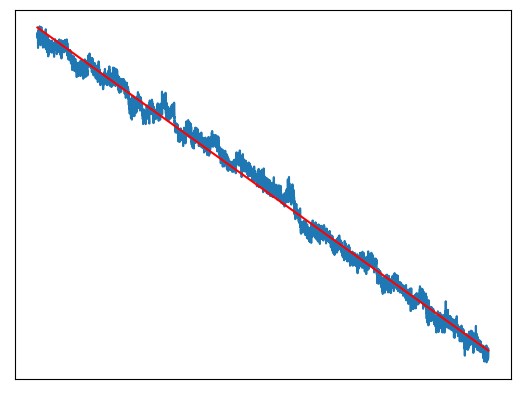

In [57]:
from sklearn.linear_model import LinearRegression
# convert the data into numpy arrays.
E = np.asarray(df['east'][df['station']==sta]).reshape(-1, 1)# reshaping was necessary to be an argument of Linear regress
t = np.asarray(df['date_year'][df['station']==sta]).reshape(-1, 1)
tt = np.linspace(np.min(t),np.max(t),1000)

# perform the linear regression. First we will use the entire available data
regr = LinearRegression()
# we will first perform the fit:
regr.fit(t,E)
# We will first predict the fit:
Epred=regr.predict(t) 

# The coefficients
print('Coefficient / Velocity eastward (mm/year): ', regr.coef_[0][0])

plt.plot(t,E);ax[0].grid(True);ax[0].set_ylabel('East (mm)')
plt.plot(t,Epred,color="red")
plt.grid(True)
plt.xticks(())
plt.yticks(())
plt.show()


To evaluate the errors of the model fit using the module ``sklearn``, we will use the following function

In [58]:
from sklearn.metrics import mean_squared_error, r2_score
# The mean squared error
print('Mean squared error (mm): %.2f'
      % mean_squared_error(E, Epred))
# The coefficient of determination: 1 is the perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(E, Epred))

Mean squared error (mm): 7.49
Coefficient of determination: 0.99


### 2.3 Bootstrapping


Now we will use again bootstrapping to estimate the slope of the regression over many resampled data.


Scikit-learn seems to have deprecated the bootstrap function, but we can find ``resample`` in the ``utils`` module. Make sure you use ``replace=True``.
For reproducible results, you can select a fixed ``random_state=int`` to be kept in the workflow. Usually bootstrapping is done over many times (unlike K-fold cross validation).

mean of the velocity estimates -6.4382164.2 and the standard deviation 0.0060364.2


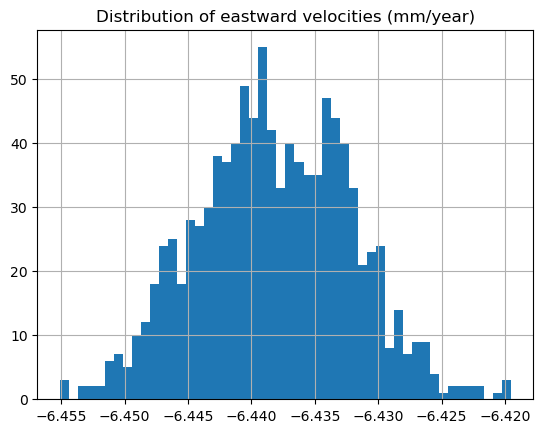

In [59]:
from sklearn.utils import resample
k=1000
vel = np.zeros(k) # initalize a vector to store the regression values
mse = np.zeros(k)
r2s = np.zeros(k)
i=0
for iik in range(k):    
    ii = resample(np.arange(len(E)),replace=True,n_samples=len(E))# new indices
    E_b, t_b = E[ii], t[ii]
    # now fit the data on the training set.
    regr = LinearRegression()
    # Fit on training data:
    regr.fit(t_b,E_b)
    Epred_val=regr.predict(t) # test on the validation set.

    # The coefficients
    vel[i]= regr.coef_[0][0]
    i+=1

# the data shows clearly a trend, so the predictions of the trends are close to each other:
print("mean of the velocity estimates %f4.2 and the standard deviation %f4.2"%(np.mean(vel),np.std(vel)))

plt.hist(vel,50);plt.title('Distribution of eastward velocities (mm/year)');plt.grid(True)
plt.show()


### 2.4 Cross validation

A model validation technique to assess how generalizable a statistical analysis is to independent data set is **cross-validation**. There are several tutorials on [cross-validation](!https://scikit-learn.org/stable/modules/cross_validation.html).

Cross-validation divides the data set between a *training* set and a *validation* set:

<div>
<img src="ValsetApproach.png" width="500"/>
</div>
From scikit-learn: concept for training and validation set.

Often the validation set ends up underestimating the prediction errors (model uncertainties) because the validation set is often smaller than the training set. To alleviate that, we can perform cross-validation over many folds of selecting a validation and training set.
<div>
<img src="grid_search_cross_validation.png" width="500"/>
</div>
*From scikit-learn*


* **Data Splitting**: Cross-validation involves *partitioning a dataset into multiple subsets*, typically a training set and a testing set. This splitting allows for model assessment and validation.

* **Estimation**: Cross-validation is primarily used to *assess the predictive performance* of machine learning models or statistical models. It helps in estimating how well a model will generalize to new, unseen data by testing its performance on data that was not used in training.

* **Correlated Data**: Cross-validation does not explicitly address correlated data, and its effectiveness can be influenced by the data splitting strategy. _When data exhibits strong correlations, it's essential to carefully design the cross-validation procedure to ensure that all subsets represent the overall data distribution_.

* **Applications**: Cross-validation is widely employed in *model selection*, *hyperparameter tuning*, and *assessing the generalization ability* of models. å

We will now randomly select a training and validation set using the ``sklearn`` module:

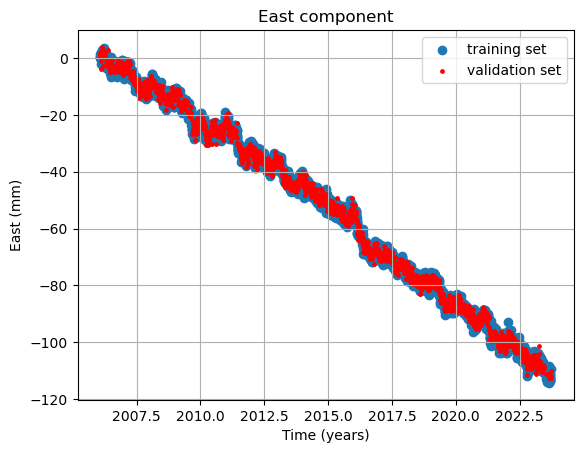

In [60]:
# we randomly select values and split the data between training and validation set.
from sklearn.model_selection import ShuffleSplit
# we split once the data between a training and a validating set 
n=1 # we do this selection once
v_size = 0.3 # 30% of the data will be randomly selected to be the validation set.

rs = ShuffleSplit(n_splits=n, test_size=.3, random_state=0)
for train_index, val_index in rs.split(E):
    E_train, E_val = E[train_index], E[val_index]
    t_train, t_val = t[train_index], t[val_index]
plt.scatter(t_train,E_train,marker="o");plt.grid(True);plt.ylabel('East (mm)')
plt.scatter(t_val,E_val,marker="o",s=6,c="red")
plt.xlabel('Time (years)')
plt.title('East component')
plt.legend(['training set','validation set'])

Now fit the data and evaluate the error

Training set: Coefficient / Velocity eastward (mm/year):  -6.442660214306567
MSE (mean square error) on training set (mm): 7.32
Coefficient of determination on training set: 0.99
MSE on validation set (mm): 7.88 and coefficient of determiniation on 0.99


Text(0.5, 1.0, 'Random selection for data split')

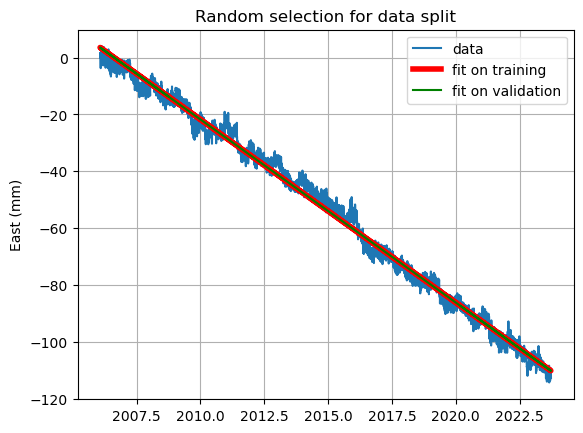

In [61]:
# now fit the data on the training set.
regr = LinearRegression()
# Fit on training data:
regr.fit(t_train,E_train)
# We will first predict the fit:
Epred=regr.predict(t_train) 
Epred_val=regr.predict(t_val) 

# The coefficients
print('Training set: Coefficient / Velocity eastward (mm/year): ', regr.coef_[0][0])

print('MSE (mean square error) on training set (mm): %.2f'
      % mean_squared_error(Epred, E_train))
# The coefficient of determination: 1 is the perfect prediction
print('Coefficient of determination on training set: %.2f'
      % r2_score(Epred, E_train))

print('MSE on validation set (mm): %.2f and coefficient of determiniation on %.2f' %(mean_squared_error(Epred_val, E_val), r2_score(Epred_val, E_val)))


plt.plot(t,E);plt.grid(True);plt.ylabel('East (mm)')
plt.plot(t_train,Epred,color="red",linewidth=4)
plt.plot(t_val,Epred_val,color="green")
plt.legend(['data','fit on training','fit on validation'])
plt.title('Random selection for data split')


We can also select the training and validation to be chronological. If the "state" of the data changes through time, this may induce a bias in the training. But let's see.

 Training set: Coefficient / Velocity eastward (mm/year):  -6.147744826538707
Validation set MSE (mm) and Coef of Determination: 17.72,0.85


Text(0.5, 1.0, 'Chronological selection for data split')

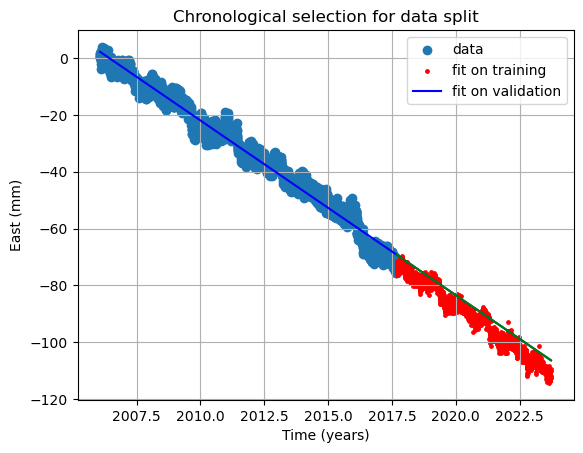

In [62]:
E_train, E_val = E[:2*len(E)//3], E[2*len(E)//3+1:]
t_train, t_val = t[:2*len(E)//3], t[2*len(E)//3+1:]
plt.scatter(t_train,E_train,marker="o");plt.grid(True);plt.ylabel('East (mm)')
plt.scatter(t_val,E_val,marker="o",s=6,c="red")
plt.xlabel('Time (years)')
plt.title('East component')
plt.legend(['training set','validation set'])

# now fit the data on the training set.
regr = LinearRegression()
# Fit on training data:
regr.fit(t_train,E_train)
# We will first predict the fit:
Epred=regr.predict(t) 
Epred_val=regr.predict(t_val) 

# The coefficients
print(' Training set: Coefficient / Velocity eastward (mm/year): ', regr.coef_[0][0])

print('Validation set MSE (mm) and Coef of Determination: %.2f,%.2f' 
%(mean_squared_error(E_val, Epred_val),r2_score(E_val, Epred_val)))


plt.plot(t,Epred,color="blue")
plt.plot(t_val,Epred_val,color="green")
plt.legend(['data','fit on training','fit on validation'])
plt.title('Chronological selection for data split')


Now you see that the choice of _training_ vs _validating_ data is important to fit a model that will generalize. 

### 2.5 Leave One Out Cross Validation

LOOCV splits the data in 2 sets (training and validation) <i>n</i> times (<i>n</i> is the number of data points). At each repeat, the training set is **all but one** data, the validation set is one element.

<div>
<img src="LOOCV.png" width="500"/>
</div>
Advantages: it has far less bias with respect to the training data. It does not overestimate the test error. Repeated LOOCV will give the exact same results.

Disadvantages: it is computationally intensive.

* **Data Splitting***: LOOCV is an extreme form of cross-validation where, for each iteration, only one data point is left out as the test set, and the remaining data is used as the training set. This process is repeated for each data point, effectively creating as many folds as there are data points.

* **Estimation**: LOOCV is primarily used for assessing model performance and estimating predictive accuracy. By evaluating the model against all data points one at a time, LOOCV provides a robust assessment of a model's ability to generalize to unseen data.

* **Correlated Data**: LOOCV, like other cross-validation methods, may not explicitly address correlated data. However, its performance can be influenced by the correlation structure in the data. For datasets with strong correlations, LOOCV may lead to models that are overly optimistic since it often tests a model on data points that are closely related to the training set.

* **Applications**: LOOCV is valuable for evaluating machine learning and statistical models, particularly when you have a limited amount of data.

In [19]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

vel = np.zeros(len(E)) # initalize a vector to store the regression values
mse_train = np.zeros(len(E))
mse_val = np.zeros(len(E))
r2s = np.zeros(len(E))
i=0
for train_index, test_index in loo.split(E):    
    E_train, E_val = E[train_index], E[val_index]
    t_train, t_val = t[train_index], t[val_index]
    # now fit the data on the training set.
    regr = LinearRegression()
    # Fit on training data:
    regr.fit(t_train,E_train)
    # We will first predict the fit:
    Epred_train=regr.predict(t_train) 
    Epred_val=regr.predict(t_val) 

    # The coefficients
    vel[i]= regr.coef_[0][0]
    mse_train[i]= mean_squared_error(E_train, Epred_train)
    mse_val[i]= mean_squared_error(E_val, Epred_val)
    r2s[i]=r2_score(E_val, Epred_val)
    i+=1

# the data shows clearly a trend, so the predictions of the trends are close to each other:
print("mean of the velocity estimates %f4.2 and the standard deviation %f4.2"%(np.mean(vel),np.std(vel)))
# the test error is the average of the mean-square-errors
print("CV = %4.2f"%(np.mean(mse_val)))

mean of the velocity estimates -6.4381084.2 and the standard deviation 0.0000794.2
CV = 7.87


LOOCV is rarely used in practice. This example is just to show the extreme end member of cross-fold validation.

### 2.6 K-fold cross validation

Designed to reduce the computational cost of LOOCV. Randomly devide over <i>k</i> groups/folds of approximately equal size. It is typical to use <i>5</i> or <i>10</i>.

<div>
<img src="Kfold.png" width="500"/>
</div>

In [20]:
from sklearn.model_selection import KFold

# let's try on 10-folds, 10 adjacent split of the data.
k=10
kf = KFold(n_splits=k)

vel = np.zeros(k) # initalize a vector to store the regression values
mse_train = np.zeros(k)
mse_val = np.zeros(k)
r2s = np.zeros(k)
i=0
for train_index, val_index in kf.split(E):    
    E_train, E_val = E[train_index], E[val_index]
    t_train, t_val = t[train_index], t[val_index]
    # now fit the data on the training set.
    regr = LinearRegression()
    # Fit on training data:
    regr.fit(t_train,E_train)
    # We will first predict the fit:
    Epred_train=regr.predict(t_train) 
    Epred_val=regr.predict(t_val) 

    # The coefficients
    vel[i]= regr.coef_[0][0]
    mse_val[i]= mean_squared_error(E_val, Epred_val)
    mse_train[i]= mean_squared_error(E_train, Epred_train)
    r2s[i]=r2_score(E_train, Epred_train)
    i+=1

# the data shows clearly a trend, so the predictions of the trends are close to each other:
print("mean of the velocity estimates %4.2f and the standard deviation %4.2f"%(np.mean(vel),np.std(vel)))
# the test error is the average of the mean-square-errors
print("mean MSE for training set : %4.2f and the validation set: %4.2f"%(np.mean(mse_train),np.mean(mse_val)))

mean of the velocity estimates -6.44 and the standard deviation 0.04
mean MSE for training set : 7.43 and the validation set: 8.78
